# T1 map calculation tutorial

Start by importing the required libraries and defining some settings:

In [8]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import warnings

from ukat.data import fetch
from ukat.utils.tools import convert_to_pi_range
from ukat.mapping.t1 import T1, magnitude_correct

# Ensure figures are rendered in the notebook
%matplotlib inline

Retrieve T1 test data using our data fetcher.
This will return 4 variables:
* `magnitude`: a 4D array with the magnitude data at all echo times.
* `phase`: a 4D array with the phase data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `TIs`: an array containing the inversion times, in seconds.
* `tss`: the temporal slice spacing of the image.

In [9]:
# Fetch test data
magnitude, phase, affine, ti, tss = fetch.t1_philips(2)
phase = convert_to_pi_range(phase)

complex_data = magnitude * (np.cos(phase) + 1j * np.sin(phase)) # convert magnitude and phase into complex data
ti = np.array(ti) * 1000  # convert TIs to ms
tss *= 1000 # convert tss into ms

Let's look at the effects of magnitude correction by plotting the raw signal from a voxel within the kidney over the range 
of inversion times.

D:\ppxad2\ownCloud\University\Renal Imaging\ukat\ukat\mapping\t1.py:380: RuntimeWarning: invalid value encountered in true_divide
  / np.abs(pixel_array[..., -1])
D:\ppxad2\ownCloud\University\Renal Imaging\ukat\ukat\mapping\t1.py:382: RuntimeWarning: invalid value encountered in true_divide
  phase_factor = np.imag(np.log(pixel_array_prime / np.abs(pixel_array)))
D:\ppxad2\ownCloud\University\Renal Imaging\ukat\ukat\mapping\t1.py:382: RuntimeWarning: invalid value encountered in log
  phase_factor = np.imag(np.log(pixel_array_prime / np.abs(pixel_array)))


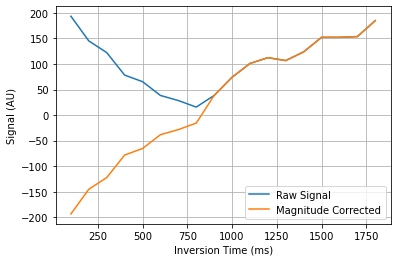

In [10]:
raw_signal = magnitude[55, 40, 2, :]
magnitude_corrected = magnitude_correct(complex_data)
magnitude_corrected_signal = magnitude_corrected[55, 40, 2, :]

plt.plot(ti, raw_signal, label='Raw Signal')
plt.plot(ti, magnitude_corrected_signal, label='Magnitude Corrected')
plt.xlabel('Inversion Time (ms)')
plt.ylabel('Signal (AU)')
plt.grid(True)
plt.legend()
plt.show()

The dynamic range of this voxel has been doubled by magnitude correcting the data. This can be used to increase the accuracy
 of our T1 maps and simplifies the equation the data is fit to by removing the absolute term.
 
Now compute the T1 maps using the `T1` class implemented in `mapping`. By default this is executed over all available CPU cores
however this can be run single-threaded by setting `multithread=False` although will obviously take much longer.

To speed things up a bit we'll just do this for the central region of the image.

In [11]:
mapper = T1(magnitude_corrected[32:-32, 32:-32, :, :], ti, multithread=True, parameters=2, tss=tss)

100%|██████████| 20455/20455 [05:32<00:00, 61.58it/s]


Display the T1 map.

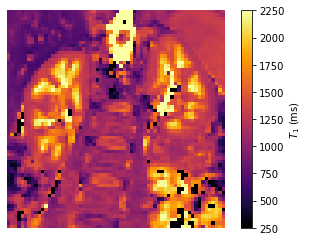

In [12]:
fig, ax1 = plt.subplots()

# Display the T1 map generated from the raw magnitude data
im = ax1.imshow(np.rot90(mapper.t1_map[:, :, 2]), cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_1$ (ms)')
ax1.axis('off')

plt.show()